In [29]:
import pandas as pd
import warnings
warnings.simplefilter('ignore')

df = pd.read_csv('./preprocessed_kb_0518.csv', encoding='ansi')
df = df[['price','year','use','depreciation','mileage', 'car_cc']]
df.head()

,price,year,use,depreciation,mileage,car_cc
0,849,2013,103,60,131493,0
1,1450,2018,52,27,60000,1598
2,655,2017,57,54,133319,0
3,999,2017,48,21,90000,1399
4,580,2011,131,83,159474,0


In [30]:
# 상관계수
df.corr().round(2)

,price,year,use,depreciation,mileage,car_cc
price,1.00,0.51,-0.53,-0.55,-0.38,0.12
year,0.51,1.00,-0.99,-0.86,-0.61,0.02
use,-0.53,-0.99,1.00,0.87,0.61,-0.02
depreciation,-0.55,-0.86,0.87,1.00,0.72,-0.00
mileage,-0.38,-0.61,0.61,0.72,1.00,0.03
car_cc,0.12,0.02,-0.02,-0.00,0.03,1.00


In [31]:
from scipy.stats import pearsonr

df.corr(method='pearson').round(2)

,price,year,use,depreciation,mileage,car_cc
price,1.00,0.51,-0.53,-0.55,-0.38,0.12
year,0.51,1.00,-0.99,-0.86,-0.61,0.02
use,-0.53,-0.99,1.00,0.87,0.61,-0.02
depreciation,-0.55,-0.86,0.87,1.00,0.72,-0.00
mileage,-0.38,-0.61,0.61,0.72,1.00,0.03
car_cc,0.12,0.02,-0.02,-0.00,0.03,1.00


In [32]:
from scipy.stats import spearmanr

df.corr(method='spearman').round(2)

,price,year,use,depreciation,mileage,car_cc
price,1.00,0.69,-0.70,-0.68,-0.50,0.19
year,0.69,1.00,-0.99,-0.90,-0.68,0.05
use,-0.70,-0.99,1.00,0.91,0.69,-0.05
depreciation,-0.68,-0.90,0.91,1.00,0.79,-0.02
mileage,-0.50,-0.68,0.69,0.79,1.00,0.01
car_cc,0.19,0.05,-0.05,-0.02,0.01,1.00


In [33]:
from scipy.stats import kendalltau

df.corr(method='kendall').round(2)

,price,year,use,depreciation,mileage,car_cc
price,1.00,0.52,-0.51,-0.50,-0.35,0.14
year,0.52,1.00,-0.95,-0.76,-0.52,0.04
use,-0.51,-0.95,1.00,0.74,0.51,-0.04
depreciation,-0.50,-0.76,0.74,1.00,0.60,-0.01
mileage,-0.35,-0.52,0.51,0.60,1.00,0.00
car_cc,0.14,0.04,-0.04,-0.01,0.00,1.00


In [34]:
from sklearn.model_selection import train_test_split

x = df[['year', 'use', 'depreciation', 'mileage']]

y = df.price

X_test, X_train, y_test, y_train = train_test_split(x, y, train_size=0.8, test_size=0.2)

In [35]:
from sklearn.linear_model import LinearRegression

#선형 회귀
mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_pred = mlr.predict(X_test)

print(mlr.score(X_train,y_train))
print(mlr.score(X_test,y_test))

0.32316250939154556
0.3125111059678073


In [36]:
# 판매가 390, 시세안전구간 414~580
test = [[2011, 134, 90, 198485]]
mlr.predict(test)

array([375.09821379])

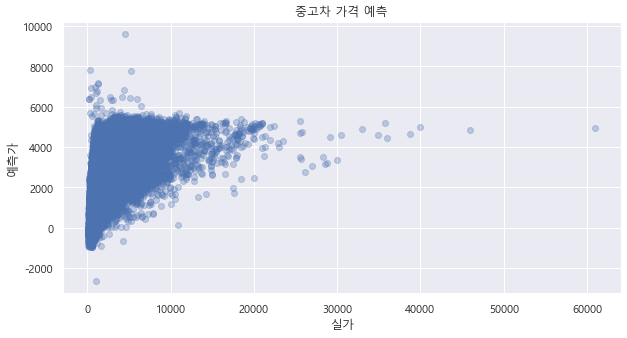

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.scatter(y_test, mlr_pred, alpha=0.3)
plt.xlabel("실가")
plt.ylabel("예측가")
plt.title("중고차 가격 예측")
plt.show()

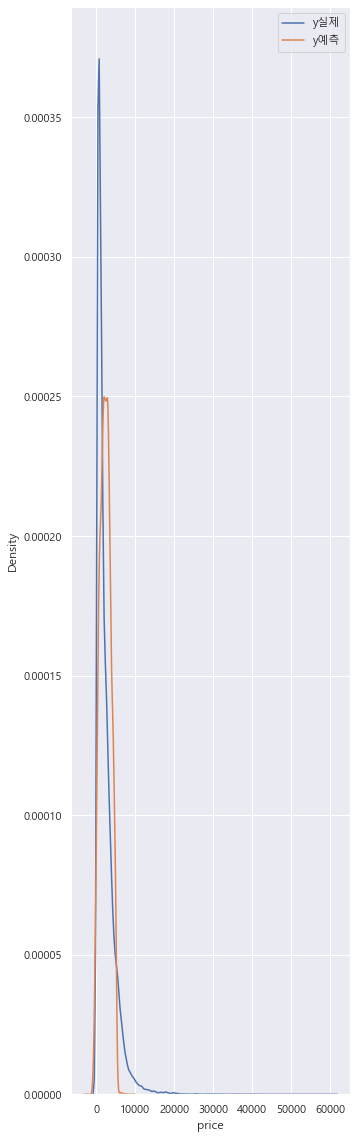

In [38]:
import seaborn as sns

sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False,
        'figure.figsize':(5,20)},
        style='darkgrid')
ax1 = sns.distplot(y, hist = False, label = 'y실제')
ax2 = sns.distplot(mlr_pred, hist = False, label = 'y예측')
plt.legend()
plt.show()

In [39]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

#다중공선성 문제 검사
folmula = "price ~ " + "+".join(df.columns[1:5])
y, X = dmatrices(folmula, data = df, return_type='dataframe')

In [40]:
df_vif = pd.DataFrame()
df_vif["colname"] = X.columns
df_vif["VIF"] = [vif(X.values, i).round(1) for i in range(len(X.columns))]
df_vif

,colname,VIF
0,Intercept,17806136.8
1,year,57.4
2,use,61.1
3,depreciation,5.4
4,mileage,2.1


In [41]:
# vif가 높은 변수 제외
df_sub = pd.concat([df.loc[:, "price":"year"],
df.loc[:, "depreciation":"mileage"]],
axis=1)
df_sub

,price,year,depreciation,mileage
0,849,2013,60,131493
1,1450,2018,27,60000
2,655,2017,54,133319
3,999,2017,21,90000
4,580,2011,83,159474
...,...,...,...,...
44241,290,2006,93,143900
44242,400,2007,94,188310
44243,630,2010,83,144233
44244,990,2012,78,136212


In [42]:
folmula = "price ~ " + "+".join(df_sub.columns[1:])
y, X = dmatrices(folmula, data = df_sub, return_type='dataframe')
df_vif = pd.DataFrame()
df_vif["colname"] = X.columns
df_vif["VIF"] = [vif(X.values, i).round(1) for i in range(X.shape[1])]
df_vif

,colname,VIF
0,Intercept,1228401.7
1,year,4.0
2,depreciation,5.1
3,mileage,2.1


In [43]:
from statsmodels.formula.api import ols

# OLS 선형회귀분석
folmula = "price ~ " + "+".join(df_sub.columns[1:])

model = ols(folmula, data = df_sub).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.304
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     6442.
Date:                Thu, 26 May 2022   Prob (F-statistic):               0.00
Time:                        10:12:45   Log-Likelihood:            -4.0031e+05
No. Observations:               44246   AIC:                         8.006e+05
Df Residuals:                   44242   BIC:                         8.007e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.965e+05   1.08e+04    -18.141      0.000   -2.18e+05   -1.75e+05
year            99.8580      5.357     18.641      0.000      89.358     110.358
depreciation   -45.0241      0.927    -48.562      0.000     -46.841     -43.207
mileage          0.0010      0.000      4.333      0.000       0.001       0.001
==============================================================================
Omnibus:                    39950.054   Durbin-Watson:                   1.683
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3466170.878
Skew:                           4.019   Prob(JB):                         0.00
Kurtosis:                      45.609   Cond. No.                     1.27e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# 테스트 데이터 설정
df_test = df.iloc[[0],[0]]
df_test['year'] = 2011
df_test['depreciation'] = 90
df_test['mileage'] = 198485

df_test

,price,year,depreciation,mileage
0,849,2011,90,198485


In [45]:
model.predict(df_test)

0    441.818866
dtype: float64

In [46]:
ols_pred = model.predict(X_test)
model.rsquared

0.3040097483170453

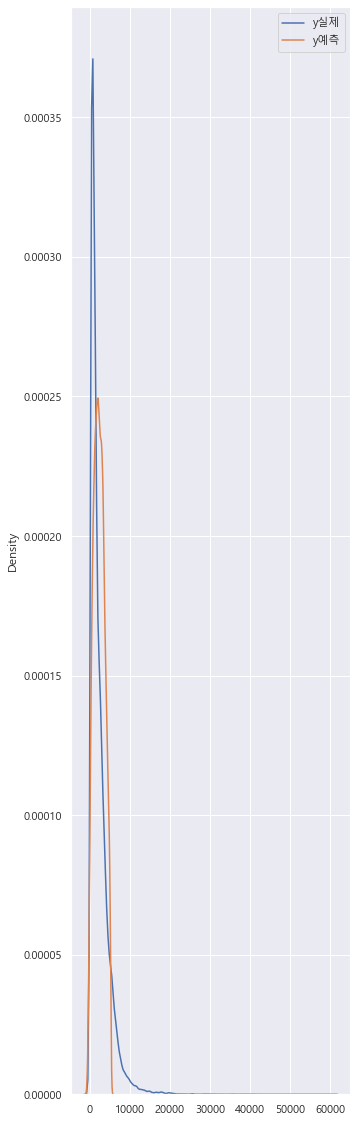

In [47]:
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False,
        'figure.figsize':(5,20)},
        style='darkgrid')
ax1 = sns.distplot(y, hist = False, label = 'y실제')
ax2 = sns.distplot(ols_pred, hist = False, label = 'y예측')
plt.legend()
plt.show()

In [48]:
# 테스트 데이터 설정 및 선형회귀분석
x = df[['year', 'depreciation', 'mileage']]

y = df.price

X_test, X_train, y_test, y_train = train_test_split(x, y, train_size=0.8, test_size=0.2)

mlr = LinearRegression()
mlr.fit(X_train, y_train)
mlr_pred = mlr.predict(X_test)

test = [[2011, 90, 198485]]
print(mlr.score(X_train,y_train))
print(mlr.score(X_test,y_test))
print(mlr.predict(test))

0.3093419372332087
0.30233160974757733
[409.91611415]


In [49]:
from sklearn.linear_model import Ridge,Lasso,ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

model_ridge = Ridge()
model_ridge.fit(X_train,y_train)
print(model_ridge.score(X_train,y_train))
print(model_ridge.score(X_test,y_test))
print(model_ridge.predict(test))

0.3093419372297639
0.30233154477388846
[409.91482448]


In [50]:
param_value = {'alpha':[0.0001,0.01,1,2,3,4]}
modelRidge = Ridge()
gridSearch_ridge = GridSearchCV(modelRidge,param_grid = param_value,cv=10)
gridSearch_ridge.fit(X_train,y_train)

print(gridSearch_ridge.best_params_)
print(gridSearch_ridge.best_score_)


{'alpha': 0.0001}
0.311923407589945


In [51]:
modelRidge = Ridge(alpha=0.0001)
modelRidge.fit(X_train,y_train)

print(modelRidge.score(X_train,y_train))
print(modelRidge.score(X_test,y_test))
print(modelRidge.predict(test))

0.30934193723320835
0.30233160974108164
[409.91611402]


In [52]:
model_lasso = Lasso()
model_lasso.fit(X_train,y_train)
print(model_lasso.score(X_train,y_train))
print(model_lasso.score(X_test,y_test))
print(model_lasso.predict(test))

0.30934190548137996
0.3023255894150316
[409.80815045]


In [53]:
modelLasso = Lasso()
gridSearch_lasso = GridSearchCV(modelLasso,param_grid = param_value,cv=10)
gridSearch_lasso.fit(X_train,y_train)

print(gridSearch_lasso.best_params_)
print(gridSearch_lasso.best_score_)

{'alpha': 0.0001}
0.31192340756421033


In [54]:
modelLasso = Lasso(alpha=0.0001)
modelLasso.fit(X_train,y_train)

print(modelLasso.score(X_train,y_train))
print(modelLasso.score(X_test,y_test))
print(modelLasso.predict(test))

0.30934193723320835
0.30233160913582546
[409.91610307]


In [55]:
model_elastic = ElasticNet(l1_ratio=0.5)
model_elastic.fit(X_train,y_train)
print(model_elastic.score(X_train,y_train))
print(model_elastic.score(X_test,y_test))
print(model_elastic.predict(test))

0.3092899508190945
0.30202910436021657
[405.03661989]


In [57]:
modelElastic = ElasticNet()
gridSearch_elastic = GridSearchCV(modelElastic,param_grid = param_value,cv=10)
gridSearch_elastic.fit(X_train,y_train)

print(gridSearch_elastic.best_params_)
print(gridSearch_elastic.best_score_)

{'alpha': 0.0001}
0.3119234073300952


In [58]:
modelElastic = ElasticNet(alpha=0.0001)
modelElastic.fit(X_train,y_train)

print(modelElastic.score(X_train,y_train))
print(modelElastic.score(X_test,y_test))
print(modelElastic.predict(test))

0.3093419372325189
0.30233158069437205
[409.91553799]
